# Digitale Bildverarbeitung

Das, in Jupyter Notebook verwendete Netz, wurde hier weiter entwickelt. In der abgegebenen PDF wird die Vorgehensweise der Entwicklung der Architektur beschrieben. Außerdem werden dort auch die Auswirkungen von Filtergröße und Aktivierungsfunktionen der Convolutional Layer beschrieben, mit Hilfe des hier gezeigten Codes getestet und anschließend die Ergebnisse in der PDF dokumentiert. Außerdem wurde der Code um eine Augmentor Pipeline ergänzt. Genaueres steht oberhalb des entsprechenden Codes aber auch in der PDF.

# Install und Import



Die auskommentierten Zeilen der zweiten Code Zelle werden benötigt um das spätere Training besser auswerten zu können. Hiermit kann die beste Testgenauigkeit val_acc einer Epoche erneut ausgegeben werden. Diese Werte werdeb auch in der Dokumentation angeführt. Dieses Verfahren ist vor allem hilfreich bei vielen Epochen. Da der Code in Google Colab programmiert wurde, muss das Programm auf die zuvor gespeicherten Daten in Google Drive zugreifen. Um keine Fehler bei der Ausführung auf anderen Geräten zu provozieren, ist deshalb der zugehörige Code ausgeklammert.

In [1]:
!pip install seaborn -q
!pip install matplotlib -q
!pip install Augmentor -qU

In [2]:
# Code to output the best val_acc after a training session
#from google.colab import drive
#!mkdir /content/drive_empty
#drive.mount('/content/drive_empty')

from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import Augmentor
import datetime
import os
import importlib
import tensorflow as tf

# Tensorflow

Um die Testdaten zu visualisieren, werden die ersten 25 Ziffern des Datensatzes ausgegeben.


11490434/11490434 [==============================] - 0s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


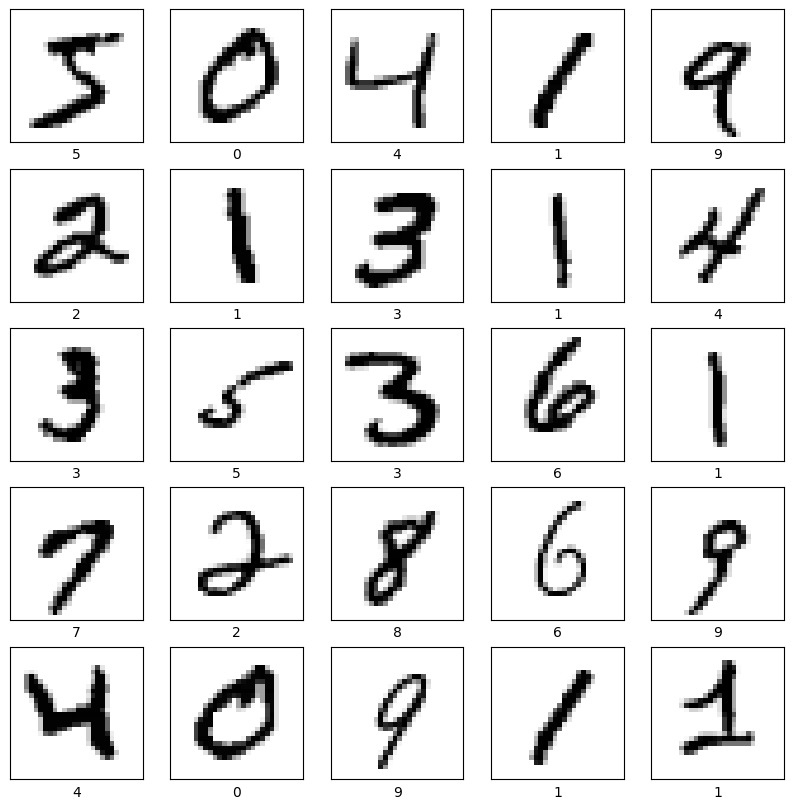

In [3]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

# Normalization of input data
x_train_normalized = x_train / 255
x_test_normalized = x_test /255

# Reshape input data to fit input layer
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

# Augmentor Pipeline

Mithilfe von Data Augmentation können die Inputdaten reduziert werden. Ein Bild wird mithilfe von mehreren Transformationen, wie Rotation, Verzerrung, Vergrößerung, Schrägstellung, Scherung usw. verändert und als weiteres Bild gespeichert und zum Trainieren des Netzes verwendet.

Um eine Idee von Data Augmentation zu bekommen, ist in dem folgenden Code die Augmentor Pipeline zu sehen und anschließend werden von jeder Ziffer 10 verschiedene Bilder ausgegeben, die mithilfe von Data Augmentation verändert wurden.

Operations: 4
	0: RotateStandard (probability=0.3 max_left_rotation=-5 max_right_rotation=5 expand=False fillcolor=0 )
	1: Distort (probability=0.3 grid_width=6 grid_height=6 magnitude=1 randomise_magnitude=True )
	2: Zoom (probability=0.3 min_factor=0.8 max_factor=1.0 )
	3: Skew (probability=0.3 skew_type=RANDOM magnitude=0.1 )
Images: 0

You can remove operations using the appropriate index and the remove_operation(index) function.


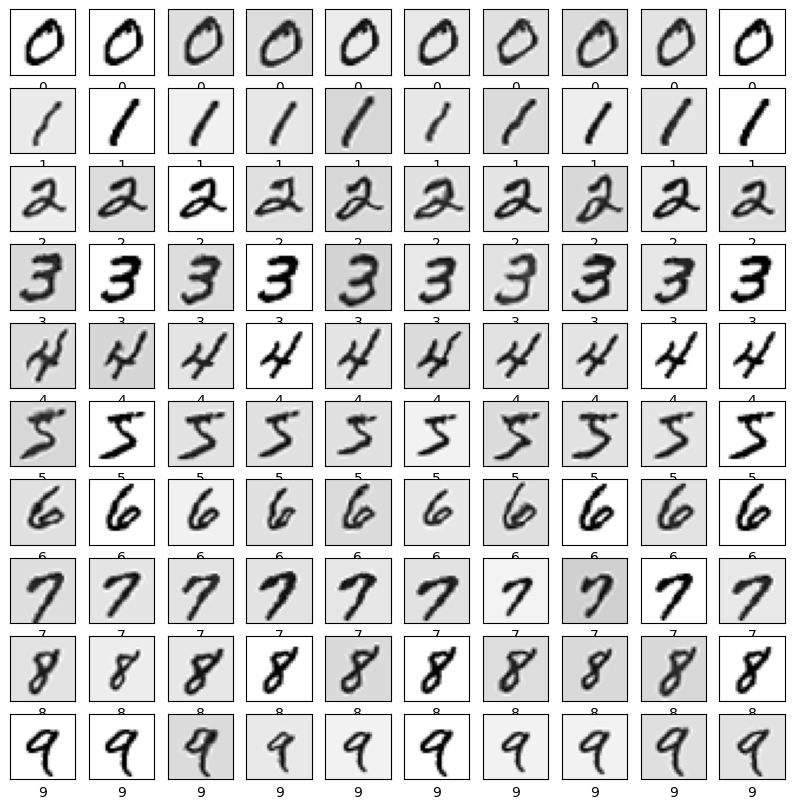

In [4]:
augmentor_pipeline = Augmentor.Pipeline()
augmentor_pipeline.rotate_without_crop(probability=0.3, max_left_rotation=5, max_right_rotation=5, fillcolor=0)
augmentor_pipeline.random_distortion(probability=0.3, grid_width=6, grid_height=6, magnitude=1)
augmentor_pipeline.zoom(probability=0.3, min_factor=0.8, max_factor=1.0)
augmentor_pipeline.skew(probability=0.3, magnitude=0.1)
#augmentor_pipeline.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
augmentor_pipeline.status()

plt.figure(figsize=(10, 10))

digit_indices = [1, 3, 5, 7, 9, 0, 13, 15, 17, 4] # Places where the individual digits appear for the first time

for idx, digit in enumerate(digit_indices):
    image_generator = augmentor_pipeline.keras_generator_from_array(x_train[digit:digit+1], y_train[digit:digit+1], batch_size=10)
    x_train_aug, y_train_aug = next(image_generator)

    for number in range(10):
        plt.subplot(10, 10, idx * 10 + number + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train_aug[number], cmap=plt.cm.binary)
        plt.xlabel(y_train_aug[number])

plt.show()

image_generator = augmentor_pipeline.keras_generator_from_array(x_train[0:3000], y_train[0:3000], batch_size=1024) # Specify which input data should be used

# Model Architecture

Auskommentiert befindet sich unterhalb der neuen Architektur der ursprüngliche Code des Jupyter Notebooks. Diese wurde weiterentwickelt und um insgesamt fünf weitere Layer ergänzt. In der PDF werden die einzelnen Schichten begründet.

In [5]:
marvin = tf.keras.models.Sequential([
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)),
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(256, activation='relu'),
 tf.keras.layers.Dropout(0.25),
 tf.keras.layers.Dense(10, activation='softmax')

 # Original neural network from jupyter notebook
 #tf.keras.layers.Flatten(input_shape=(28,28,1)),     # Flatten-Schicht
 #tf.keras.layers.Dense(128, activation='relu'),      # Dense-Schicht
 #tf.keras.layers.Dropout(0.2),                       # Dropout-Schicht
 #tf.keras.layers.Dense(10, activation='softmax')     # Dense-Schicht (Annahme: 10 Klassen für Klassifikation)

])

marvin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0

# Training

Bevor das Netz trainiert wird, müssen die Verluste berechnet werden und der Optimizer initialisiert werden. Danach kann das Netz unter Angabe der Trainingsbedingungen trainiert werden.

Für die Dokumentation wurden dauerhaft folgende Trainingsparameter verwendet:
- gesamte Input Daten
- Epochen: 60
- Batch Size: 1024
- Learning Rate: 0.0001

Wird die Augmentor Pipeline verwendet, so verändern sich auch die Trainingsparameter. Für die Dokumentation wurden folgende Trainingsparameter verwendet.
- die ersten 3000 Bilder der Input Daten
- Epochen: 300
- Batch Size: 1024
- Learning Rate: 0.001



In [6]:
# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], marvin(x_train[sampleID-1:sampleID]).numpy()).numpy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

marvin.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


#logdir = os.path.join("./drive", "MyDrive", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # Must be commented out, if output of best val_acc not needed
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Code to set up callback object in TensorFlow, which is used to save models during training, needed for output of the best val_acc
# Must be commented out, if output of best val_acc not needed
#checkpoint_filepath = f'./drive/MyDrive/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=False,
#    monitor='val_accuracy',
#    mode='max',
#    save_best_only=True)


# trainig of the network
marvin.fit(

    # classic training
    x_train,
    y_train,
    epochs= 60,
    batch_size= 1024,

    # training with augmentor pipeline
    #image_generator,
    #steps_per_epoch=1,
    #epochs=300,

    validation_data=(x_test, y_test),
    callbacks=[
        #model_checkpoint_callback, # Must be commented out, if output of best val_acc not needed
        #tensorboard_callback # Must be commented out, if output of best val_acc not needed
        ]
)

marvin.summary()

# Code to output the best val_acc after a training session
# Must be commented out, if output of best val_acc not needed
#model = tf.keras.models.load_model(checkpoint_filepath)
#results = model.evaluate(x_test, y_test)
#print(f"test loss: {results[0]}, test accuracy: {results[1]}")
#os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

tf.Tensor(2.3025851, shape=(), dtype=float32)
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


59/59 [==============================] - 15s 68ms/step - loss: 0.7870 - accuracy: 0.7503 - val_loss: 1.8304 - val_accuracy: 0.8338
Epoch 2/60
59/59 [==============================] - 2s 36ms/step - loss: 0.2068 - accuracy: 0.9381 - val_loss: 1.5508 - val_accuracy: 0.9413
Epoch 3/60
59/59 [==============================] - 2s 38ms/step - loss: 0.1265 - accuracy: 0.9624 - val_loss: 1.2420 - val_accuracy: 0.9654
Epoch 4/60
59/59 [==============================] - 2s 37ms/step - loss: 0.0926 - accuracy: 0.9728 - val_loss: 0.8797 - val_accuracy: 0.9752
Epoch 5/60
59/59 [==============================] - 2s 37ms/step - loss: 0.0751 - accuracy: 0.9777 - val_loss: 0.5638 - val_accuracy: 0.9789
Epoch 6/60
59/59 [==============================] - 2s 36ms/step - loss: 0.0622 - accuracy: 0.9817 - val_loss: 0.3232 - val_accuracy: 0.9822
Epoch 7/60
59/59 [==============================] - 2s 36ms/step - loss: 0.0533 - accuracy: 0.9842 - val_loss: 0.1691 - val_accuracy: 0.9841
Epoch 8/60
59/59 [=====

In [7]:
# Safe Marvin in Keras style (HDF5) marvin0001 for LR=0.0001
model_name = 'marvin0001.h1'
marvin.save(model_name, save_format='h5')

print('Success! You saved Marvin as: ', model_name)

Success! You saved Marvin as:  marvin0001.h1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluating

An den Evaluierungsfunktionen wurde nichts verändert. Diese dienen lediglich der Überprüfung und Visualisierung der Trainingsergebnisse.

In [8]:
# load a saved marvin configuration
model_name = 'marvin0001.h1'
marvin_reloaded = tf.keras.models.load_model(model_name)

# Prediction on the test set
predictions = marvin_reloaded.predict([x_test])
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)


313/313 [==============================] - 1s 2ms/step


<ipython-input-9-9baaff025309>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


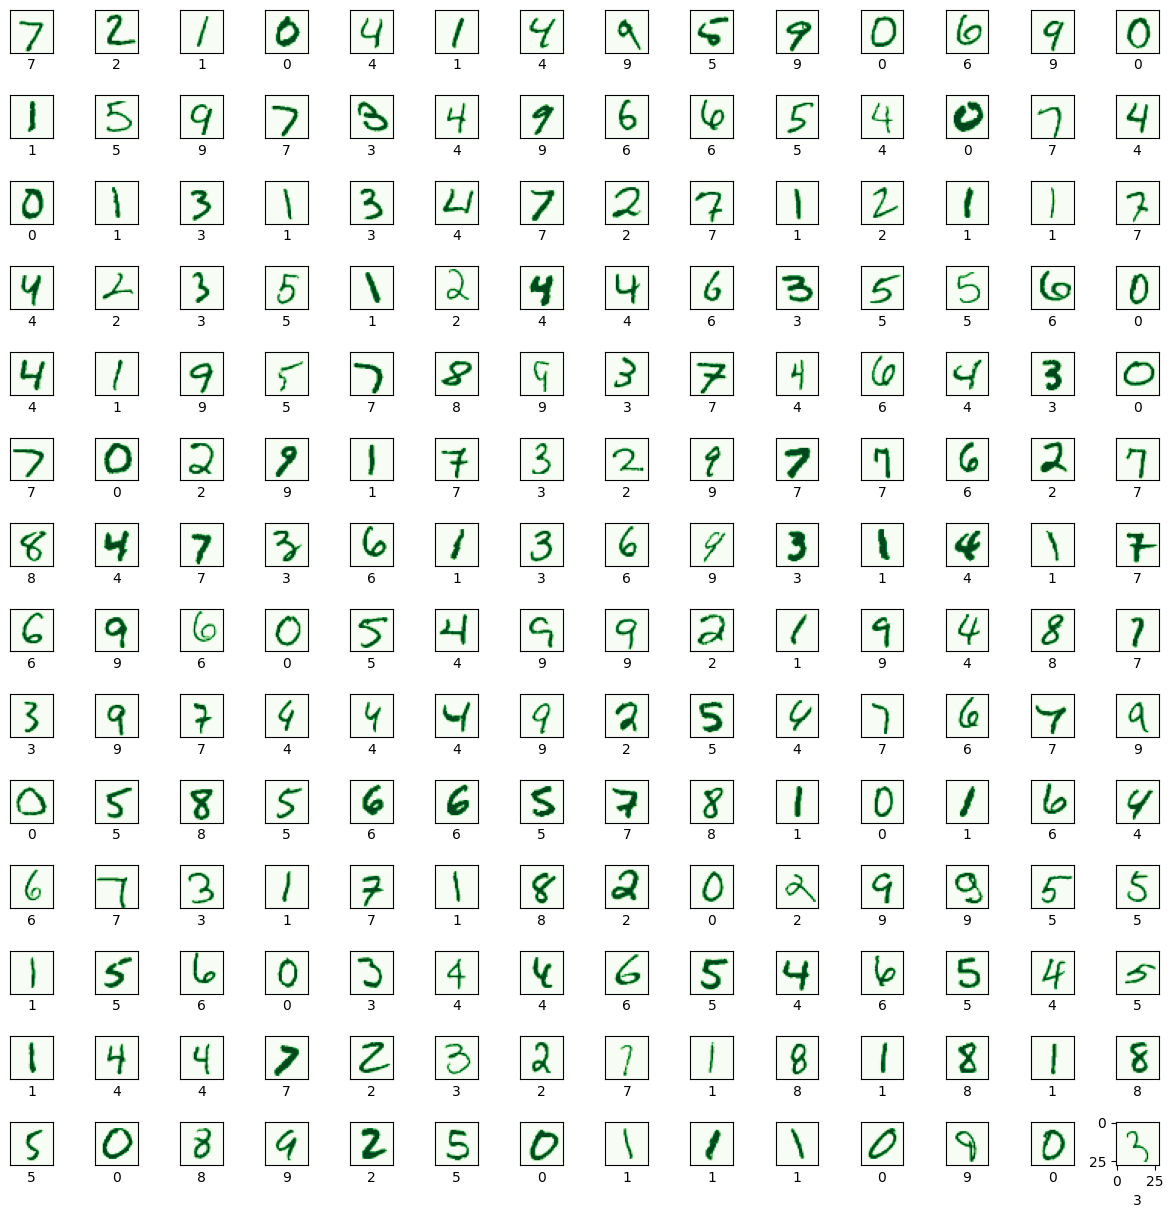

In [9]:
# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

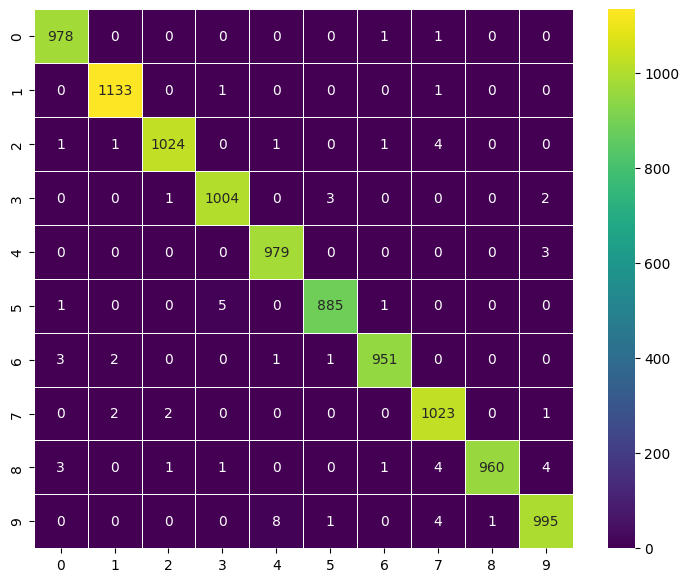

In [10]:
# Empirical Approach

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()